
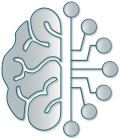

**Start at:** Sunday 07 July 2024, 21:55:34  
**Hostname:** device-15.home (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/pyPhysChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

In [1]:
import os
import sys

cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color
vID.init(cwd0)
import tools4pyPhysChem as t4pPC

#cancel the "last show-up" behaviour of Jupyter notebooks
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



# <!-- TITLE --> Prediction of a 2D trajectory on a potential energy surface via RNN
<!-- DESC : Based on --> 
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->





<div style="intro">
    
**Adaptation of a fidle notebook**

<a href="https://fidle.cnrs.fr/"><img width="200" src="./ML-Figures/00-Fidle-logo-01.svg"></img></a>

<img width="500" src="./ML-Figures/Four_wells.png" style="display:block; margin-left:auto; margin-right:auto;" id="ladybug"/>

</div>

## Step 1 - Initialisation


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
from numpy import cos,array
from sympy import *
import math, random
from math import sin,cos,pi
import matplotlib.pyplot as plt

import pandas as pd
import h5py, json
import os,time,sys

from importlib import reload
from IPython.display import display,Image,Markdown,HTML
from datetime import datetime
import datetime, time

sys.path.append('..')


2024-07-07 21:55:37.687187: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-07 21:55:37.687415: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-07 21:55:37.690904: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-07 21:55:37.736993: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-07 21:55:38.471735: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

### 1.1 - Definition of some usefull functions

In [3]:
def plot_2d_serie(data, figsize=(10,8), monocolor=False, hide_ticks=True, lw=2, ms=4, save_as='auto'):
    """
    Plot a 2d dataset as a trajectory
    args:
        data:      Dataset to plot
        figsize:   Figure size ( (10,8))
        monocolor: Monocolor line or not. (False)
    return:
        nothing
    """
    # ---- Get x,y, min and max
    #
    n     = len(data)
    k     = int(n/100)
    x,y   = data[:,0], data[:,1]
 
    # ---- Draw it
    #
    fig = plt.figure(figsize=figsize)
    ax = plt.axes()

    # ---- Monocolor or gray gradient
    #
    if monocolor:
        ax.plot(x,y)
    else:
        for i in range(0,100):
            a= (200-i)/200
            ax.plot(x[i*k:(i+1)*k+1], y[i*k:(i+1)*k+1], '-', color=(a,a,a),lw=lw,zorder=1)

    # ---- Last point
    #
    ax.plot(x[n-1], y[n-1], 'o', color='C1',ms=ms,zorder=2)
    
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('axis=0')
    ax.set_ylabel('axis=1')
    
    if hide_ticks:
        ax.set_yticks([])
        ax.set_xticks([])
        
    plt.show()    

In [4]:
  def plot_2d_segment(sequence_real, sequence_pred, figsize=(10,8), ms=6, lw=1, hide_ticks=True, save_as='auto'):
    """
    Plot a 2d segment real and predicted
    args:
        sequence_real: Real sequence
        sequence_pred: Predicted sequence
        figsize:       Figure size ( (10,8) )
        ms:            Marker size (6)
    return:
        nothing
    """
    k = len(sequence_pred)
    x,y = sequence_real[:,0],sequence_real[:,1]
    u,v = sequence_pred[:,0],sequence_pred[:,1]
    
    fig = plt.figure(figsize=figsize)

    ax = plt.axes()
    
    # ---- Draw real sequence without prediction
    #
    ax.plot(x[:-k], y[:-k],   'o', color='C0', fillstyle='full', zorder=2, ms=ms)
    ax.plot(x, y,             '-', color='C0', lw=lw, zorder=1)
    
    # ---- What we expect
    #
    ax.plot(x[-k:], y[-k:], 'o', ms=ms, markeredgecolor='C0', markerfacecolor='white', zorder=2)

    # ---- What we have
    #
    ax.plot(u, v,                            'o',  color='C1',fillstyle='full',zorder=2, ms=ms)
    ax.plot( [x[-1-k],u[0]], [y[-1-k],v[0]], '--', color='C1',lw=lw, zorder=1)
    ax.plot(u, v,                            '--', color='C1',lw=lw, zorder=1)

    ax.set_aspect('equal', 'box')
    ax.set_xlabel('axis=0')
    ax.set_ylabel('axis=1')
    
    if hide_ticks:
        ax.set_yticks([])
        ax.set_xticks([])

    plt.show()

In [5]:
def np_print(*args, precision=3, linewidth=120):
    with np.printoptions(precision=precision, linewidth=linewidth):
        for a in args:
            print(a)

def subtitle(t):
    display(Markdown(f'<br>**{t}**'))
    
def mkdir(path):
    os.makedirs(path, mode=0o750, exist_ok=True)
    

In [6]:
def chrono_start():
    global _chrono_start, _chrono_stop
    _chrono_start=time.time()

# return delay in seconds or in humain format
def chrono_stop(hdelay=False):
    global _chrono_start, _chrono_stop
    _chrono_stop = time.time()
    sec = _chrono_stop - _chrono_start
    if hdelay : return hdelay_ms(sec)
    return sec
    
def chrono_show():
    print('\nDuration : ', hdelay_ms(time.time() - _chrono_start))
    
def hdelay_ms(delay):
    if type(delay) is not datetime.timedelta:
        delay=datetime.timedelta(seconds=delay)
    sec = delay.total_seconds()
    hh = sec // 3600
    mm = (sec // 60) - (hh * 60)
    ss = sec - hh*3600 - mm*60
    ms = (sec - int(sec))*1000
    return f'{hh:02.0f}:{mm:02.0f}:{ss:02.0f} {ms:03.0f}ms'

In [7]:
def plot_history(history, figsize=(8,6), 
                 plot={"Accuracy":['accuracy','val_accuracy'], 'Loss':['loss', 'val_loss']},
                 save_as='auto'):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(history.history[c])
        plt.legend(curves, loc='upper left')
        if save_as=='auto':
            figname='auto'
        else:
            figname=f'{save_as}_{fig_id}'
            fig_id+=1
        plt.show()


In [8]:
def plot_multivariate_serie(sequence, labels=None, predictions=None, only_features=None,
                            columns=3, width=5,height=4,wspace=0.3,hspace=0.2,ms=6,lw=1,
                            save_as='auto', time_dt=1, hide_ticks=False):
    
    sequence_len = len(sequence)
    features_len = sequence.shape[1]
    if only_features is None : only_features=range(features_len)
    if labels is None        : labels=range(features_len)
    
    t  = np.arange(sequence_len)    
    if predictions is None:
        dt = 0
    else:
        dt = len(predictions)
        sequence_with_pred = sequence.copy()
        sequence_with_pred[-dt:]=predictions

    rows = math.ceil(features_len/columns)
    fig  = plt.figure(figsize=(columns*width, rows*height))
    fig.subplots_adjust(wspace=0.3,hspace=0.2)
    n=1
    for i in only_features:
        ax=fig.add_subplot(rows, columns, n)
        
        # ---- Real sequence without prediction
        #
        ax.plot( t[:-dt],sequence[:-dt,i], 'o',  markersize=ms, color='C0', zorder=2)
        ax.plot( t,sequence[:,i],          '-',  linewidth=lw,  color='C0', label=labels[i],zorder=1)

        # ---- What we expect
        #
        ax.plot(t[-dt:], sequence[-dt:,i], 'o', markeredgecolor='C0',markerfacecolor='white',ms=6)
        
        if predictions is not None:
            ax.plot(t[-dt-1:], sequence_with_pred[-dt-1:,i], '--',  lw=lw, fillstyle='full',  ms=ms, color='C1',zorder=1)
            ax.plot(t[-dt:],   predictions[:,i],             'o',   lw=lw, fillstyle='full',  ms=ms, color='C1',zorder=2)

        if hide_ticks:
            ax.set_yticks([])
            ax.set_xticks([])
        
        ax.legend(loc="upper left")
        n+=1
     
    plt.show()

In [9]:
def get_prediction(dataset, model, iterations=1):

    # ---- Initial sequence
    #
    s=random.randint(0,len(dataset)-sequence_len-iterations)

    sequence_pred = dataset[s:s+sequence_len].copy()
    sequence_true = dataset[s:s+sequence_len+iterations].copy()
    
    # ---- Iterate 
    #
    sequence_pred = list(sequence_pred)

    for i in range(iterations):
        sequence   = sequence_pred[-sequence_len:]
        prediction = model.predict( np.array([sequence]),verbose=0 )
        sequence_pred.append(prediction[0])

    # ---- Extract the predictions    
    #
    prediction = np.array(sequence_pred[-iterations:])
    sqr_diff=(sequence_true[sequence_len:sequence_len+iterations]-prediction)**2
    mean_sqr_diff = np.mean(sqr_diff)
    
    return sequence_true,prediction

### 1.2 - Parameters

In [10]:
# ---- About dataset
#
features_len = 2
sequence_len = 50
predict_len  = 50

# ---- About training
#
scale        = 1.        # Percentage of dataset to be used (1=all)
train_prop   = .8        # Percentage for train (the rest being for the test)
batch_size   = 64

## Step 2 - Generation of dataset


### 2.1 - Generate coordinates the rescaled and normalized dataset
#### A particle moving on a four-wells potenial energy surface (PES)
<img width="500px" src="./ML-Figures/Four_wells.png" style="display:block; margin-left:auto; margin-right:auto;" id="ladybug"/>
To generate the data, we will use classical molecular dynamics approach (MD) <i/>i.e.</i> solve Newton’s equations of motions in order to simulate the dynamical behaviour of particles. To calculate the positions of a particle at a given time, the "Velocity-Verlet propagator" will be used where positions and velocities are propagated over time according to the following equations.
\begin{align}    
\mathbf{x_i(t+δt)=x_i(t)+v_i(t).δt+\frac{1}{2} γ_i(t).δt^2} \\    
\end{align}
    
\begin{align}   
\mathbf{v_i(t+δt)=v_i(t)+\frac{γ_i(t)+γ_i(t+δt)}{2}.δt} \\
\end{align}
    
whith $v(t)$, the velocity (first derivatives of positions with respect to time) and $γ(t)$, the acceleration (second derivatives of positions with respect to time).
    
To determine accelerations, we use Newton's law, which relates acceleration to force and thus to the energy gradient.
    
\begin{align}
\vec{\gamma}_i(t) & = \frac{\vec{F_i}(t)}{M_i} \\
\end{align}
    
    
\begin{align}
\vec{F_i}(t)&=-\vec{\nabla}_i{\mathbf{V(x(t))}} \\
\end{align}
    


Dataset generated.
Train shape is :  (40000, 2)
Test  shape is :  (10000, 2)


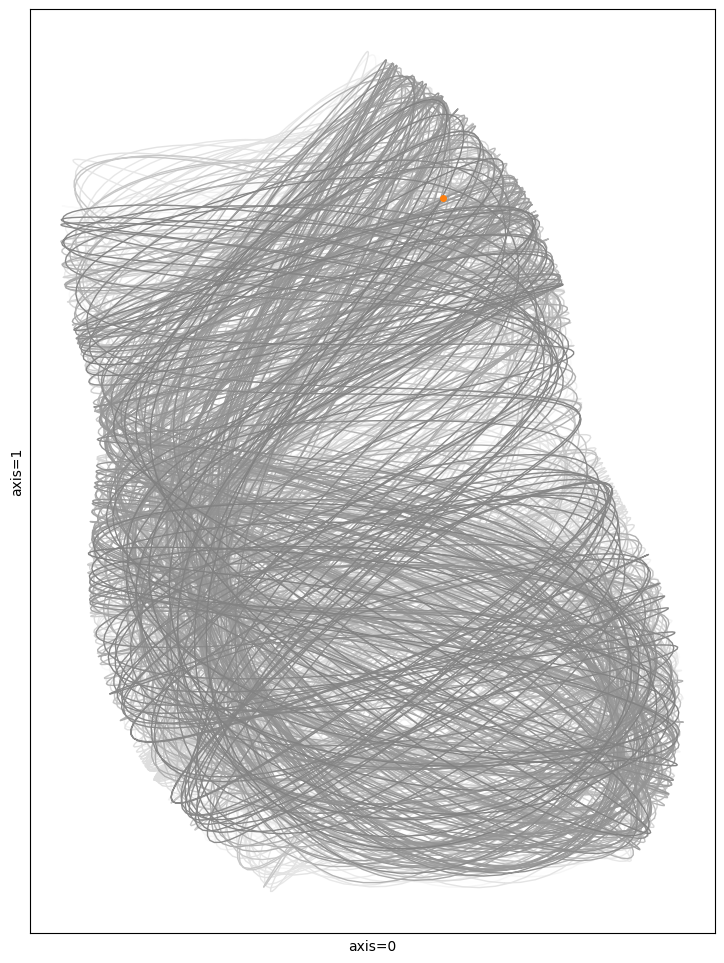

In [12]:
# parameters for the PES
kx = 1
ky = 1
m = 1 

# parameters for the trajectory calculation
x,y = 0,0           # initital positions
vx,vy = 0.5,0.0     # initital velocities
t = 0
max_t = 5000
delta_t = 0.1

positions=[]

# Definition of the Potential
xx = Symbol('xx')
yy = Symbol('yy')
f1x = 1/2*kx*(xx-5)**2+4   #definition of the 1st well (harmonic potential)
f2x = 1/2*kx*(xx+2)**2+0   #definition of the 2nd well (harmonic potential)
f1y = 1/2*ky*(yy-1)**2+2   #definition of the 3rd well (harmonic potential)
f2y = 1/2*ky*(yy+2)**2+0   #definition of the 4th well (harmonic potential)
fpfx = f1x+f2x
fmfx = ((f1x-f2x)**2+2**2)
fpfy = f1y+f2y
fmfy = ((f1y-f2y)**2+2**2)
potx = 1/2*fpfx-1/2*sqrt(fmfx)
poty = 1/2*fpfy-1/2*sqrt(fmfy)

f = potx+poty+xx*yy/5   # final expression of the potential

gradx = f.diff(xx) 
grady = f.diff(yy) 

f = lambdify([xx,yy],f)
gradx = lambdify([xx,yy],gradx)
grady = lambdify([xx,yy],grady)

# Velocity verlet propagation
for t in np.arange(0., max_t, delta_t): 
    positions.append([x,y])
    x1 = x + vx*delta_t-0.5*gradx(x,y)*delta_t**2
    y1 = y + vy*delta_t-0.5*grady(x,y)*delta_t**2
    vx1=vx-0.5*(gradx(x,y)+gradx(x1,y1))*delta_t
    vy1=vy-0.5*(grady(x,y)+grady(x1,y1))*delta_t
    x = x1
    y = y1
    vx = vx1
    vy = vy1
    
# ---- Build rescaled dataset
#
n = int( len(positions)*scale )
dataset = np.array(positions[:n])

k = int(len(dataset)*train_prop)
x_train = dataset[:k]
x_test  = dataset[k:]

# ---- Normalize
#
mean = x_train.mean()
std  = x_train.std()

x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

print("Dataset generated.")
print("Train shape is : ", x_train.shape)
print("Test  shape is : ", x_test.shape)

plot_2d_serie(x_train[:len(dataset)], figsize=(12,12), lw=1,ms=4,save_as='01-dataset')

### 2.2 - Have a look
An extract from the data of what we want to predict (in red), from a segment (in blue)

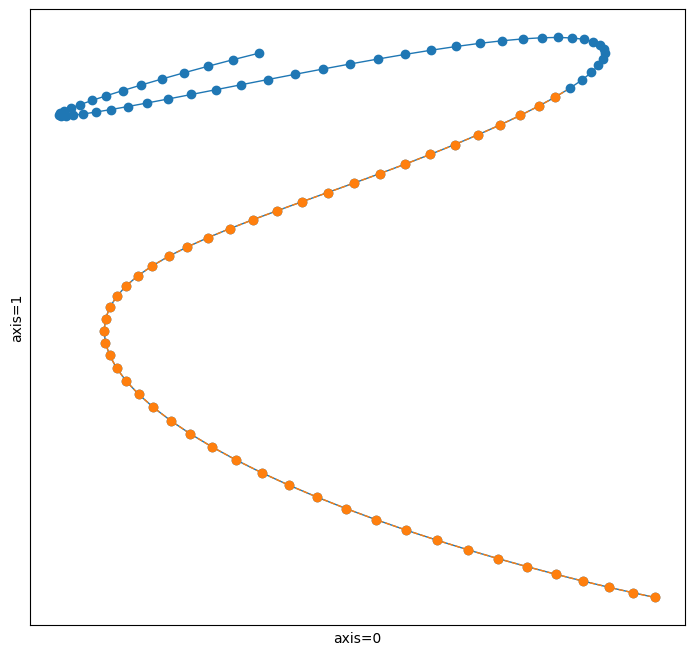

In [13]:
k1,k2 = sequence_len, predict_len
i = random.randint(0,len(x_test)-k1-k2)
j = i+k1

plot_2d_segment( x_test[i:j+k2], x_test[j:j+k2],ms=6, save_as='02-objectives')

### 2.3 - Prepare data generator

In [14]:
# ---- Train generator
#
train_generator = TimeseriesGenerator(x_train, x_train, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(x_test,  x_test,  length=sequence_len,  batch_size=batch_size)

# ---- About
#
subtitle('About the splitting of our dataset :')

x,y=train_generator[0]
print(f'Number of batch trains available : ', len(train_generator))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)

x,y=train_generator[0]


<br>**About the splitting of our dataset :**

Number of batch trains available :  625
batch x shape :  (64, 50, 2)
batch y shape :  (64, 2)


## Step 3 - Create a model

### 3.1 - Define the model
<div class="introT" title="Adaptation of the neural network">

</div>
<div class="intro">
- add one or more Conv1D layers before LSTM layer:
<div class="intro">
    
```
model.add( keras.layers.Conv1D(filters=32,kernel_size=256,strides=1, padding="same"))
```
</div>
<br>  
- add Maxpooling after Conv1D :
<div class="intro">
    
```
model.add( keras.layers.MaxPooling1D(pool_size=2, strides=None, padding='valid'))
```
</div>
<br> 
- add one or more Dense layers after LSTM :   
<div class="intro">
    
```
model.add(keras.layers.Dense(50, activation='relu', name='Dense_n1'))
```
</div>
<br> 
- add dropout after Dense layers :
<div class="intro">
    
```
model.add(keras.layers.Dropout(0.2))
```
</div>

In [15]:
model = keras.models.Sequential()
model.add( keras.layers.InputLayer(shape=(sequence_len,features_len)))
model.add( keras.layers.LSTM(128,return_sequences=False, recurrent_activation='tanh', activation='tanh') )
model.add(keras.layers.Dense(features_len))

model.summary()

2024-07-07 21:56:08.202236: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,330 (263.01 KB)

 Trainable params: 67,330 (263.01 KB)

 Non-trainable params: 0 (0.00 B)

## Step 4 - Compile and run

### 4.1 - Add callback

In [16]:
mkdir('./run/models')

best_callbacks= [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10,restore_best_weights=False),
                 keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, min_lr=0.000001, verbose=1, mode="auto", min_delta=1e-4),
                 keras.callbacks.ModelCheckpoint('./run/models/model_2.keras',monitor="val_loss",verbose=1,save_best_only=True,save_weights_only=False,mode="min",save_freq="epoch",initial_value_threshold=None,)]#

### 4.2 - Compile

In [17]:
model.compile(optimizer='adam', 
              loss='mse', 
              metrics   = ['mae'] )

### 4.3 - Fit


In [18]:
history=model.fit(train_generator, 
                  epochs=10, 
                  verbose=1,
                  validation_data = test_generator,
                  callbacks = [best_callbacks])

Epoch 1/10
  3/625 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - loss: 0.5919 - mae: 0.6025

/home/romuald/Python3/ML/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3178 - mae: 0.3561
Epoch 1: val_loss improved from inf to 0.00039, saving model to ./run/models/model_2.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - loss: 0.3172 - mae: 0.3555 - val_loss: 3.8750e-04 - val_mae: 0.0152 - learning_rate: 0.0010
Epoch 2/10
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 4.9164e-04 - mae: 0.0165
Epoch 2: val_loss improved from 0.00039 to 0.00008, saving model to ./run/models/model_2.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - loss: 4.9157e-04 - mae: 0.0165 - val_loss: 8.0746e-05 - val_mae: 0.0068 - learning_rate: 0.0010
Epoch 3/10
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 6.7606e-04 - mae: 0.0175
Epoch 3: val_loss did not improve from 0.00008
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - loss: 6.7528e-04 - mae: 0.0175 - val_loss: 1.3588e-04 - val_mae: 0.0092 - learning_rate: 0.0010
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 7.2750e-04 - mae: 0.0178
Epoch 4: ReduceLROn

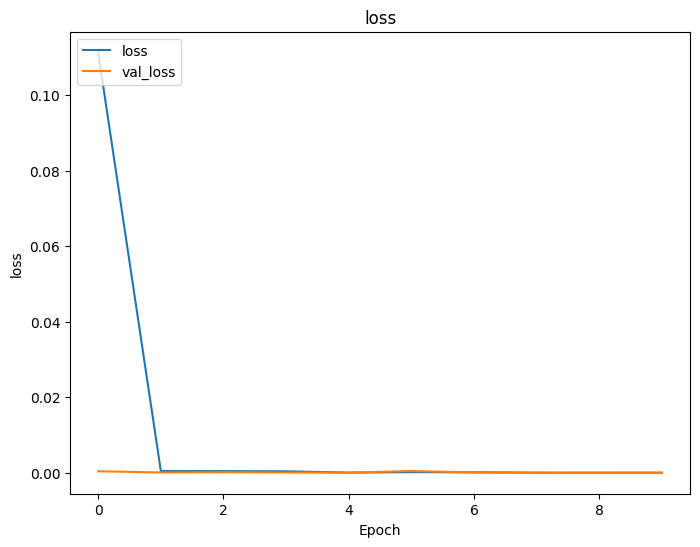

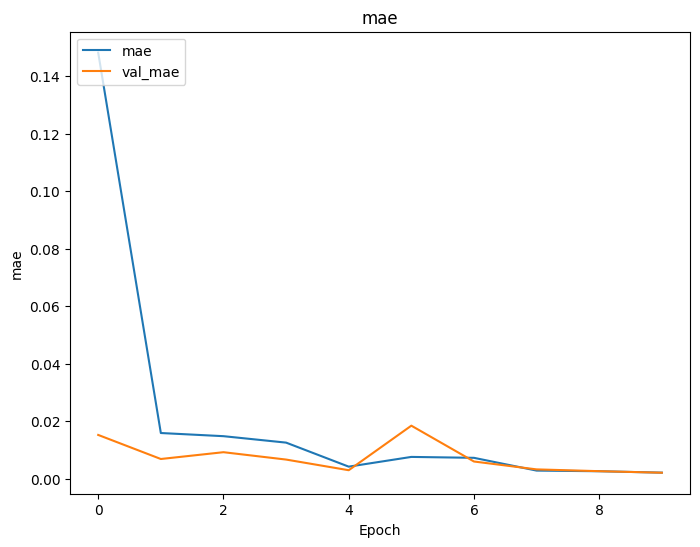

In [19]:
plot_history(history,plot={'loss':['loss','val_loss'], 'mae':['mae','val_mae']}, save_as='03-history')

## Step 5 - Predict

### 5.1 - Load model

In [24]:
loaded_model = tf.keras.models.load_model('./run/models/model_2.keras')

print('Loaded.')

Loaded.


### 5.2 - Make a 1-step prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


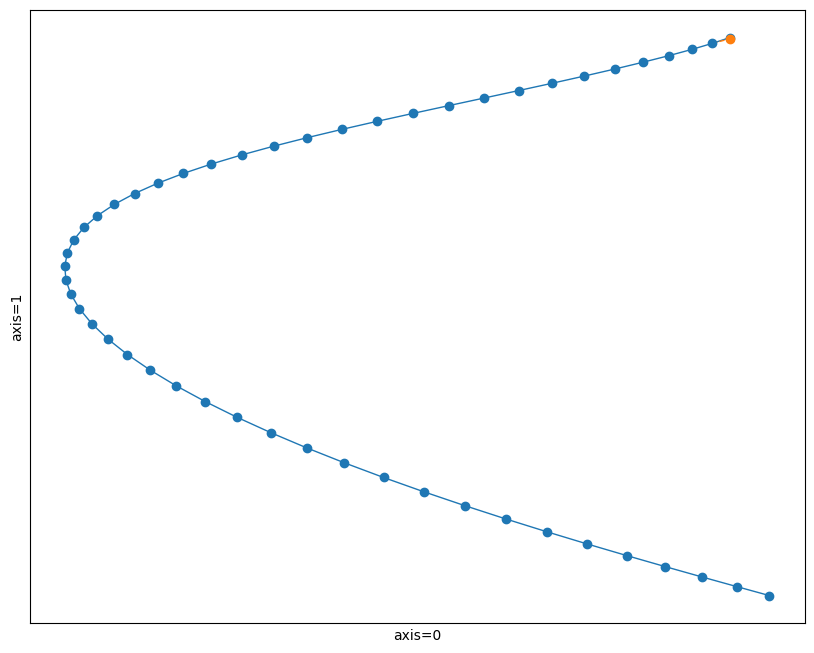

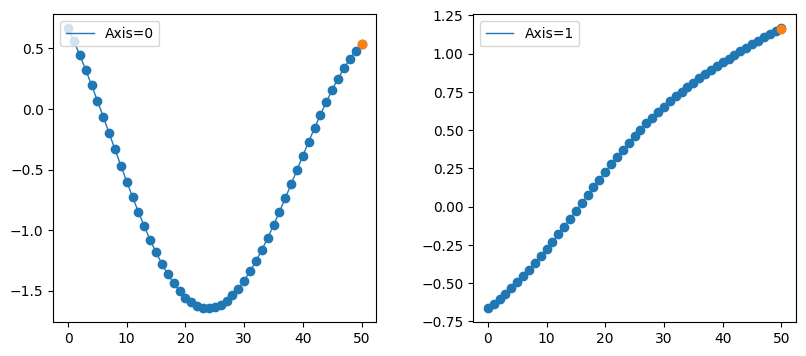

In [25]:
s=random.randint(0,len(x_test)-sequence_len)

sequence      = x_test[s:s+sequence_len]
sequence_true = x_test[s:s+sequence_len+1]

sequence_pred = model.predict( np.array([sequence]) )
plot_2d_segment(sequence_true, sequence_pred)
plot_multivariate_serie(sequence_true, predictions=sequence_pred, labels=['Axis=0', 'Axis=1'],save_as='04-one-step-prediction')

### 5.3 - Make n-steps prediction


Number of predicted points: 1
RMSD calculated on 10 predictions
RSMD_TOTAL= 0.0019
RSMD-X_TOTAL= 0.0018
RSMD-Y_TOTAL= 0.0021
LAST PREDICTION 


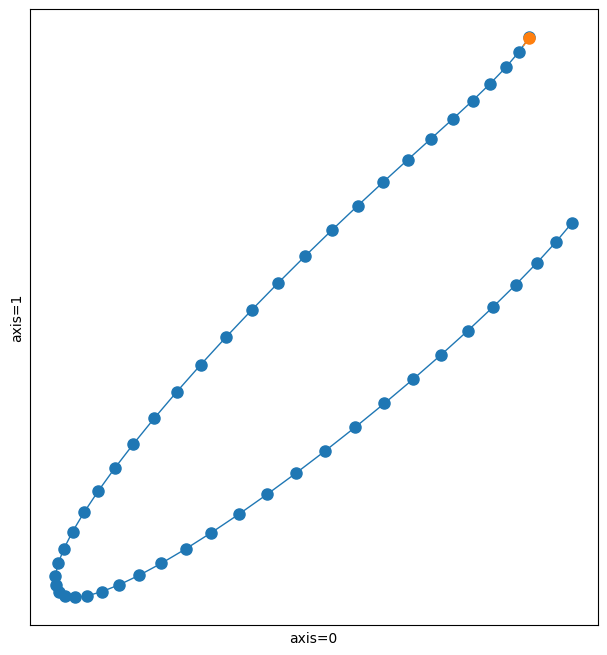

Number of predicted points: 20
RMSD calculated on 10 predictions


In [ ]:
diffx_total = 0
diffy_total = 0
rang = 10
for iter in (1,20):
    print("\033[1;31mNumber of predicted points:", iter)
    print("RMSD calculated on",'{:2d}'.format(rang),"predictions\033[0m")
    for i in range(0,rang):
        sequence_true, sequence_pred = get_prediction(x_test, model, iterations=iter)
        diff = sequence_pred[0:iter] - sequence_true[sequence_len:sequence_len+iter]
        diffx = diff[:,0]**2
        diffy = diff[:,1]**2
        diffx_total = diffx_total + diffx.mean(axis = 0)
        diffy_total = diffy_total + diffy.mean(axis = 0)
    print('RSMD_TOTAL=','{:06.4f}'.format(sqrt((diffx_total/rang+diffy_total/rang)/2)))
    print('RSMD-X_TOTAL=','{:06.4f}'.format(sqrt(diffx_total/rang)))
    print('RSMD-Y_TOTAL=','{:06.4f}'.format(sqrt(diffy_total/rang)))  
    print("\033[1;31mLAST PREDICTION \033[0m")
    plot_2d_segment(sequence_true, sequence_pred, ms=8,  save_as='02-prediction-norm')

In [23]:
vID.end(cwd0)

**End at:** Sunday 07 July 2024, 22:00:51  
**Duration:** 00:05:17 018ms

<p style="text-align: center"><img width="800px" src="./config/svg/logoEnd.svg" style="margin-left:auto; margin-right:auto"/></p>